In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#**Fetching the data**
---

In [2]:
def fetchData(linkToFile):
  return pd.read_csv(linkToFile)

In [3]:
dataset = fetchData("https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/639388c2cbc2120a14dcf466e85730eb8be498bb/iris.csv")

#**Looking at the data and its characteristics**
---

In [4]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


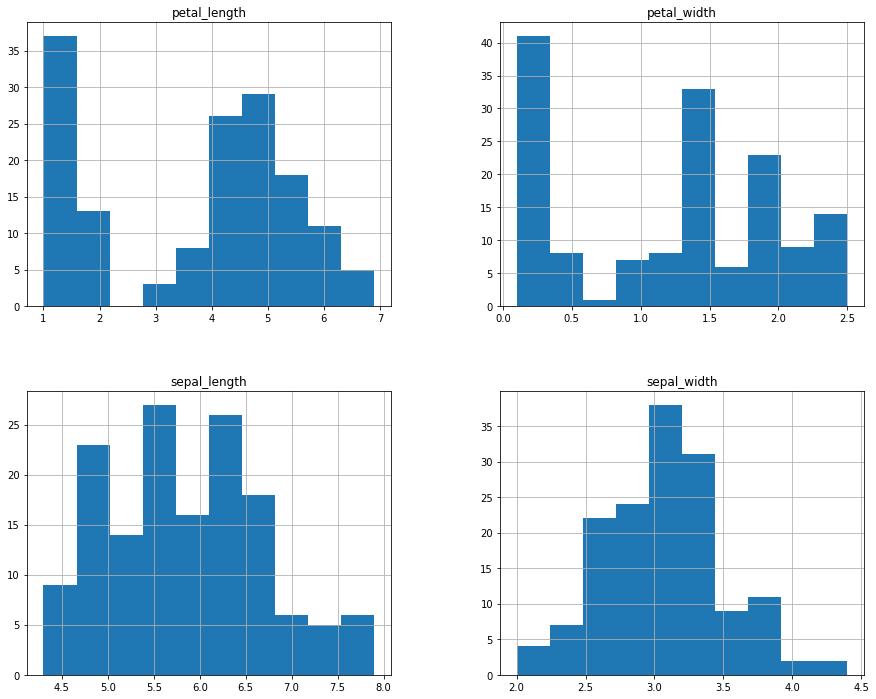

In [7]:
dataset.hist(figsize=(15,12))
plt.show()

In [8]:
dataset.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,1.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,1.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,1.000000


#**A very basic classification**
---

As seen in the correlation table above, the features **sepal_length**, **petal_length** and **petal_width** are highly correlated; whereas the feature **sepal_width** stands out from them.

In [9]:
column_names = list(dataset.columns)

**Trying to find out which feature will be good for classification**
---

Since **sepal_lenght**, **petal_length** and **petal_width** are highly correlated, I am going to see which one of them can classify the dataset *best*.

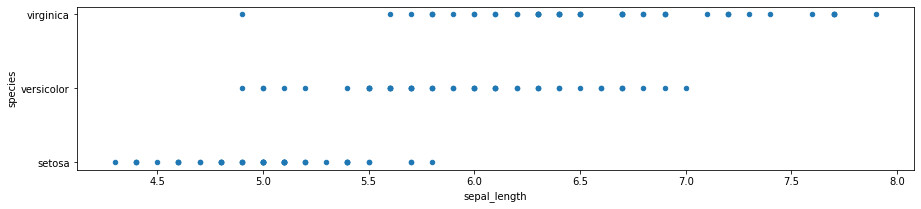

In [10]:
dataset.plot.scatter(x=column_names[0], y=column_names[4], figsize=(15,3))   #sepal_length
plt.show()

From what I see in the plot above, it will be quite impossible to classify from the feature **sepal_length** alone. Let us look into its correlated features and see if they can meet out need.

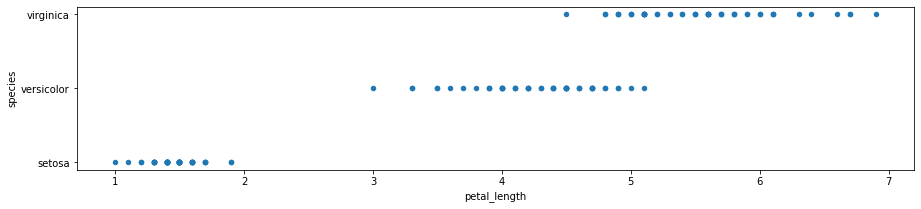

In [11]:
dataset.plot.scatter(x=column_names[2], y=column_names[4], figsize=(15,3))   #petal_length
plt.show()

Well, this looks promising. This feature's characteristic is very close to what we need to classify our data.

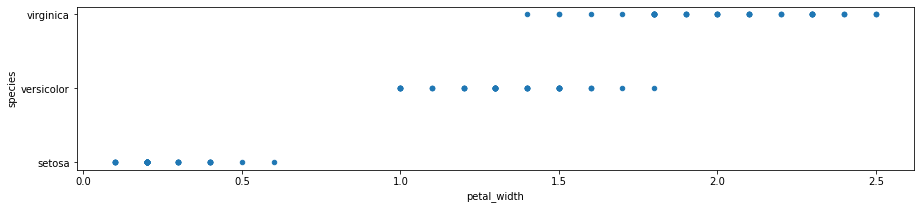

In [12]:
dataset.plot.scatter(x=column_names[3], y=column_names[4], figsize=(15,3))   #petal_width
plt.show()

This feature seems good too, although the previous feature seems better to use for classifiaation.

**Using only one feature to classify data**
---

I'll use the feature **petal_length** first to see how it performs. For that, I'll need a dictionary to store the information.

In [13]:
class_names = dataset[column_names[4]].unique()

In [14]:
class_gen = {}
for class_name in class_names:
  class_gen[class_name] = {"min":10, "max":0.1}

In [15]:
class_gen

{'setosa': {'max': 0.1, 'min': 10},
 'versicolor': {'max': 0.1, 'min': 10},
 'virginica': {'max': 0.1, 'min': 10}}

Since the minimum petal lenth is 1 and maximum petal length is 6.9, there is no need to take larger initial value to start comparison.

Now, I'll iterate through the dataset to update the dictionary and then use it to classify the test data.

To train, validate and test this, I'll split the original dataset into three sets.

In [16]:
numpy_dataset = dataset[["petal_length","species"]].to_numpy()

In [17]:
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(numpy_dataset, test_size=0.2, random_state=42)
train_set, test_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [18]:
def model_trainer(train_set, class_gen):
  '''
  Input:
  train_set: a numpy array, on which the model is to be created
  class_gen: a dicionary which intially has the class names and random number for their maximum and minimum value

  Output:
  class_gen: a dictionary that contains the limits for each class

  Process:
  a loop will iterate through the given numpy array. For each entry, it will match with its corresponding class in the dictionary and compare the length/width ranges and update accordingly.
  '''
  for flower in train_set:
    if (flower[0] > class_gen[flower[1]]["max"]):
      class_gen[flower[1]]["max"] = flower[0]
    elif (flower[0] < class_gen[flower[1]]["min"]):
      class_gen[flower[1]]["min"] = flower[0]

  return class_gen

In [19]:
class_gen = model_trainer(train_set, class_gen)

Let's see what our trainer has generated.

In [20]:
class_gen

{'setosa': {'max': 1.9, 'min': 1.1},
 'versicolor': {'max': 5.0, 'min': 3.0},
 'virginica': {'max': 6.7, 'min': 4.5}}

Let's create a function that will measure our classifier's accuracy.

In [21]:
def predict_class(class_gen, flower_feature):
  for probable_class, class_info in class_gen.items():
    if (flower_feature >= class_info["min"]) and (flower_feature <= class_info["max"]):
      return probable_class
  return "Nothing found"  # the function will return this only if it hasn't been able to locate the given feature in the class boundaries

In [22]:
def calculate_accuracy(validation_set, class_gen):
  '''
  Input:
  validation_set: a numpy array, which will be used to find classification accuracy
  class_gen: a dictionary of classification info

  Output:
  accuracy: a floating point number (denoting percentage)

  Process:
  A loop will iterate through the validation_set, predict the class from class_gen (using the predict_class() function) and match it with the given class.
  Count if the prediction was correct.
  At the end ofthe loop, just calculate the percentage and return.
  '''
  correct_prediction = 0
  for flower in validation_set:
    # flower[0] is the feature
    # flower[1] is the class
    if (flower[1] == predict_class(class_gen, flower[0])):
      correct_prediction += 1
    accuracy = (correct_prediction/len(validation_set))*100

  return accuracy

In [23]:
calculate_accuracy(validation_set, class_gen)

93.33333333333333

That seems really good for such a simple classification!

Let's see how well it performs on test data.

In [24]:
calculate_accuracy(test_set, class_gen)

87.5

Not bad!

Let's see some of the outputs from test data.

In [25]:
import random

In [26]:
feature_value = test_set[random.randint(0,len(test_set)-1)][0]
print("Flower of petal length {} is {}".format(feature_value,predict_class(class_gen, feature_value)))
# pick an index from test_set randomly and check its class

Flower of petal length 1.4 is setosa


**Other feature's performance on the same model**
---

**Sepal length**

In [27]:
class_gen = {}
for class_name in class_names:
  class_gen[class_name] = {"min":10, "max":0.1}

In [28]:
numpy_dataset = dataset[["sepal_length","species"]].to_numpy()
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(numpy_dataset, test_size=0.2, random_state=42)
train_set, test_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [29]:
class_gen = model_trainer(train_set, class_gen)

In [30]:
class_gen

{'setosa': {'max': 5.8, 'min': 4.3},
 'versicolor': {'max': 7.0, 'min': 4.9},
 'virginica': {'max': 7.7, 'min': 4.9}}

The limits do not look good. Let's see its performance.

In [31]:
calculate_accuracy(validation_set, class_gen)

53.333333333333336

That is nowhere near good.

In [32]:
calculate_accuracy(test_set, class_gen)

58.333333333333336

In [33]:
feature_value = test_set[random.randint(0,len(test_set)-1)][0]
print("Flower of Sepal length {} is {}".format(feature_value,predict_class(class_gen, feature_value)))

Flower of Sepal length 4.4 is setosa


But with an accuracy so low, we can't really trust this model.\
Let's check about other features.

**Sepal width**

In [34]:
class_gen = {}
for class_name in class_names:
  class_gen[class_name] = {"min":10, "max":0.1}

numpy_dataset = dataset[["sepal_width","species"]].to_numpy()
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(numpy_dataset, test_size=0.2, random_state=42)
train_set, test_set = train_test_split(train_set, test_size=0.2, random_state=42)

class_gen = model_trainer(train_set, class_gen)
class_gen

{'setosa': {'max': 4.4, 'min': 2.9},
 'versicolor': {'max': 3.2, 'min': 2.0},
 'virginica': {'max': 3.8, 'min': 2.2}}

In [35]:
calculate_accuracy(validation_set, class_gen)

53.333333333333336

In [36]:
calculate_accuracy(test_set, class_gen)

58.333333333333336

In [37]:
feature_value = test_set[random.randint(0,len(test_set)-1)][0]
print("Flower of Sepal width {} is {}".format(feature_value,predict_class(class_gen, feature_value)))

Flower of Sepal width 2.3 is versicolor


**Petal Width**

In [38]:
class_gen = {}
for class_name in class_names:
  class_gen[class_name] = {"min":10, "max":0.1}

numpy_dataset = dataset[["petal_width","species"]].to_numpy()
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(numpy_dataset, test_size=0.2, random_state=42)
train_set, test_set = train_test_split(train_set, test_size=0.2, random_state=42)

class_gen = model_trainer(train_set, class_gen)
class_gen

{'setosa': {'max': 0.6, 'min': 0.1},
 'versicolor': {'max': 1.8, 'min': 1.0},
 'virginica': {'max': 2.5, 'min': 1.4}}

In [39]:
calculate_accuracy(validation_set, class_gen)

93.33333333333333

In [40]:
calculate_accuracy(test_set, class_gen)

91.66666666666666

In [41]:
feature_value = test_set[random.randint(0,len(test_set)-1)][0]
print("Flower of Petal width {} is {}".format(feature_value,predict_class(class_gen, feature_value)))

Flower of Petal width 1.3 is versicolor


# **Discussion**

So, from the observation above, it is pretty clear that the features **petal_length** and **petal_width** are self-sufficient to classify the iris dataset, though using **petal_width** resulted in higher accuracy on test data.